# L.A. County places and U.S. Census tracts

In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
import geopandas as gpd
import jenkspy
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
import json
import numpy as np
import altair as alt
import altair_latimes as lat

In [4]:
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
from datetime import datetime, date
from slugify import slugify

In [5]:
alt.themes.register("latimes", lat.theme)
alt.themes.enable("latimes")
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

---

### Get tracts

In [6]:
src_tracts = gpd.read_file(
    "input/la_county_gis_2010_tracts_demographics_1566095293689.geojson"
)

In [7]:
src_tracts.columns = (
    src_tracts.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_", regex=False)
    .str.replace("(", "", regex=False)
    .str.replace(")", "", regex=False)
    .str.replace("/", "_", regex=False)
)

In [8]:
src_tracts = src_tracts.to_crs("EPSG:3311")

In [9]:
src_tracts["tract_area"] = round(src_tracts["geometry"].area / 2.59e6, 2)

In [10]:
src_tracts.head(1)

,objectid,ct10,label,documentation,p0010001,p0030001,p0030002,p0030003,p0030004,p0030005,p0030006,p0030007,p0030008,p0040001,p0040002,p0040003,p0050001,p0050002,p0050003,p0050004,p0050005,p0050006,p0050007,p0050008,p0050009,...,h0050005,h0050006,h0050007,h0050008,h0100001,h0130001,h0130002,h0130003,h0130004,h0130005,h0130006,h0130007,h0130008,medhinc,ages_0_9,ages_10_19,ages_20_29,ages_30_39,ages_40_49,ages_50_59,ages_60_69,ages_70_79,ages_80_over,geometry,tract_area
0,1,911001,9110.01,http://www.census.gov/prod/cen2010/doc/sf1.pdf,4201,4201,3167,161,39,100,16,564,154,4201,3101,1100,4201,3101,2718,154,19,99,15,11,85,...,18,150,0,117,4170,1673,462,615,254,171,75,49,47,53266.0,386,529,421,378,561,843,629,310,144,"POLYGON ((213977.451 -381620.371, 210742.806 -...",144.42


### Slim down the dataframe

In [11]:
latracts = gpd.GeoDataFrame(
    src_tracts[
        [
            "ct10",
            "geometry",
            "medhinc",
            "p0010001",
            "p0040003",
            "p0050003",
            "p0030003",
            "p0030005",
            "h0130001",
            "h0130008",
            "h0130002",
            "tract_area",
        ]
    ]
)

In [12]:
latracts.rename(
    columns={
        "ct10": "tract",
        "medhinc": "median_income",
        "p0010001": "pop",
        "p0040003": "latino",
        "p0050003": "anglo",
        "p0030003": "black",
        "p0030005": "asian",
        "h0130001": "total_housing_units",
        "h0130002": "total_single_units",
        "h0130008": "total_seven_more_units",
    },
    inplace=True,
)

In [13]:
latracts.head()

,tract,geometry,median_income,pop,latino,anglo,black,asian,total_housing_units,total_seven_more_units,total_single_units,tract_area
0,911001,"POLYGON ((213977.451 -381620.371, 210742.806 -...",53266.0,4201,1100,2718,161,100,1673,47,462,144.42
1,576301,"POLYGON ((168128.224 -468669.535, 168066.801 -...",32288.0,4176,2137,615,845,470,1590,51,579,0.21
2,670500,"POLYGON ((154462.914 -470115.717, 154396.829 -...",219688.0,1860,102,1379,29,303,663,14,98,2.99
3,651302,"POLYGON ((152393.536 -466322.058, 152311.024 -...",102727.0,6311,605,4260,60,1121,2484,9,537,0.93
4,575402,"POLYGON ((167710.128 -467872.283, 167627.515 -...",28782.0,4065,3132,150,511,172,954,99,111,0.13


### Export geojson

In [14]:
latracts.to_file("output/latracts_3311.geojson", driver="GeoJSON")

---

### Tracts population

In [15]:
tracts_src = pd.read_csv(
    "/Users/mhustiles/data/github/census-data-downloader/\
processed/acs5_2018_population_tracts.csv",
    dtype={"geoid": "str", "tract": "str", "state": str, "county": str},
)

In [16]:
ca_tracts = tracts_src[tracts_src["name"].str.contains(", California")]

In [17]:
ca_tracts.head()

,geoid,name,universe,universe_annotation,universe_moe,universe_moe_annotation,state,county,tract
3560,06059052511,"Census Tract 525.11, Orange County, California",6295.0,NaN,404.0,NaN,06,059,052511
3561,06037127520,"Census Tract 1275.20, Los Angeles County, Cali...",4544.0,NaN,368.0,NaN,06,037,127520
3562,06107001400,"Census Tract 14, Tulare County, California",5202.0,NaN,456.0,NaN,06,107,001400
3563,06067008113,"Census Tract 81.13, Sacramento County, California",3626.0,NaN,215.0,NaN,06,067,008113
3564,06071000824,"Census Tract 8.24, San Bernardino County, Cali...",5401.0,NaN,393.0,NaN,06,071,000824


In [18]:
tracts_geo = pd.merge(latracts, ca_tracts, on="tract")

In [19]:
tracts_geo.rename(
    columns={"name_x": "placename", "universe": "population"}, inplace=True
)

In [20]:
tracts_geo.head()

,tract,geometry,median_income,pop,latino,anglo,black,asian,total_housing_units,total_seven_more_units,total_single_units,tract_area,geoid,name,population,universe_annotation,universe_moe,universe_moe_annotation,state,county
0,911001,"POLYGON ((213977.451 -381620.371, 210742.806 -...",53266.0,4201,1100,2718,161,100,1673,47,462,144.42,06037911001,"Census Tract 9110.01, Los Angeles County, Cali...",4380.0,NaN,555.0,NaN,06,037
1,576301,"POLYGON ((168128.224 -468669.535, 168066.801 -...",32288.0,4176,2137,615,845,470,1590,51,579,0.21,06037576301,"Census Tract 5763.01, Los Angeles County, Cali...",3990.0,NaN,330.0,NaN,06,037
2,670500,"POLYGON ((154462.914 -470115.717, 154396.829 -...",219688.0,1860,102,1379,29,303,663,14,98,2.99,06037670500,"Census Tract 6705, Los Angeles County, California",1630.0,NaN,147.0,NaN,06,037
3,651302,"POLYGON ((152393.536 -466322.058, 152311.024 -...",102727.0,6311,605,4260,60,1121,2484,9,537,0.93,06037651302,"Census Tract 6513.02, Los Angeles County, Cali...",6032.0,NaN,395.0,NaN,06,037
4,575402,"POLYGON ((167710.128 -467872.283, 167627.515 -...",28782.0,4065,3132,150,511,172,954,99,111,0.13,06037575402,"Census Tract 5754.02, Los Angeles County, Cali...",4113.0,NaN,299.0,NaN,06,037


In [21]:
tracts_geo.drop(
    ["universe_annotation", "universe_moe", "universe_moe_annotation"],
    axis=1,
    inplace=True,
)

In [22]:
tracts_geo.head()

,tract,geometry,median_income,pop,latino,anglo,black,asian,total_housing_units,total_seven_more_units,total_single_units,tract_area,geoid,name,population,state,county
0,911001,"POLYGON ((213977.451 -381620.371, 210742.806 -...",53266.0,4201,1100,2718,161,100,1673,47,462,144.42,06037911001,"Census Tract 9110.01, Los Angeles County, Cali...",4380.0,06,037
1,576301,"POLYGON ((168128.224 -468669.535, 168066.801 -...",32288.0,4176,2137,615,845,470,1590,51,579,0.21,06037576301,"Census Tract 5763.01, Los Angeles County, Cali...",3990.0,06,037
2,670500,"POLYGON ((154462.914 -470115.717, 154396.829 -...",219688.0,1860,102,1379,29,303,663,14,98,2.99,06037670500,"Census Tract 6705, Los Angeles County, California",1630.0,06,037
3,651302,"POLYGON ((152393.536 -466322.058, 152311.024 -...",102727.0,6311,605,4260,60,1121,2484,9,537,0.93,06037651302,"Census Tract 6513.02, Los Angeles County, Cali...",6032.0,06,037
4,575402,"POLYGON ((167710.128 -467872.283, 167627.515 -...",28782.0,4065,3132,150,511,172,954,99,111,0.13,06037575402,"Census Tract 5754.02, Los Angeles County, Cali...",4113.0,06,037


---

### Get L.A. County places

In [23]:
places_geo = gpd.read_file(
    "input/cities-neighborhoods-unincorporated-la-county.geojson"
).fillna("")

In [24]:
places_geo = places_geo.to_crs("EPSG:3311")

In [25]:
places_geo.columns = places_geo.columns.str.lower()

In [26]:
# places_geo["NAME"] = np.where(
#     (places_geo["LCITY"] == "Los Angeles") | (places_geo["LCITY"] == "Unincorporated"),
#     places_geo["COMMUNITY"],
#     places_geo["LCITY"],
# )

In [27]:
len(places_geo)

348

In [28]:
# places_geo.drop(
#     [
#         "LCITY",
#         "LABEL",
#         "COMMUNITY",
#         "CONFIRMED",
#         "SUSPECTED",
#         "RECOVERED",
#         "DEATHS",
#         "Shape__Area",
#         "Shape__Length",
#         "OBJECTID",
#     ],
#     axis=1,
#     inplace=True,
# )

In [29]:
places_geo["place_area"] = round(places_geo["geometry"].area / 2.59e6, 2)

In [30]:
places_geo.head()

,name,geometry,place_area
0,Agoura Hills,"MULTIPOLYGON (((117201.354 -426752.672, 116472...",7.82
1,Bellflower,"MULTIPOLYGON (((174818.350 -454427.122, 174810...",6.18
2,Beverly Hills,"MULTIPOLYGON (((148374.547 -432436.704, 148309...",5.71
3,Burbank,"MULTIPOLYGON (((156006.516 -426897.025, 156303...",17.34
4,Calabasas,"MULTIPOLYGON (((120408.368 -426638.916, 120344...",13.76


In [31]:
places_geo.to_file("output/places_geo_3311.geojson", driver="GeoJSON")

---

### What pct of each tract is in each place? 

In [32]:
merged = gpd.sjoin(latracts, places_geo)

<AxesSubplot:>

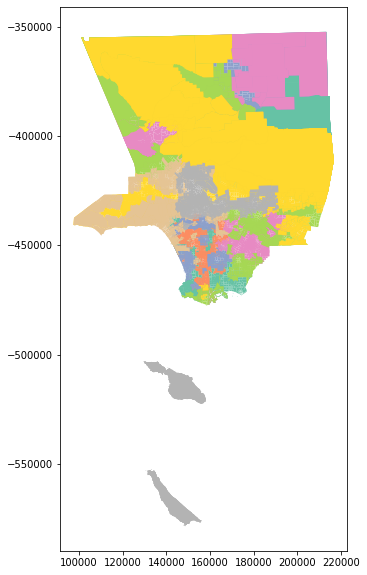

In [33]:
merged.plot(figsize=(10, 10), cmap="Set2")

In [34]:
merged.iloc[1]

tract                                                                106111
geometry                  POLYGON ((147146.4667574 -409906.7401738493, 1...
median_income                                                       80536.0
pop                                                                    4334
latino                                                                 2552
anglo                                                                  1194
black                                                                   221
asian                                                                   326
total_housing_units                                                    1313
total_seven_more_units                                                   68
total_single_units                                                      179
tract_area                                                             1.48
index_right                                                             146
name        

In [35]:
merged.head()

,tract,geometry,median_income,pop,latino,anglo,black,asian,total_housing_units,total_seven_more_units,total_single_units,tract_area,index_right,name,place_area
0,911001,"POLYGON ((213977.451 -381620.371, 210742.806 -...",53266.0,4201,1100,2718,161,100,1673,47,462,144.42,146,Angeles National Forest,691.19
308,106111,"POLYGON ((147146.467 -409906.740, 147147.789 -...",80536.0,4334,2552,1194,221,326,1313,68,179,1.48,146,Angeles National Forest,691.19
408,106510,"POLYGON ((140831.743 -408408.723, 140805.063 -...",72950.0,5108,3261,1027,362,391,1446,78,221,2.21,146,Angeles National Forest,691.19
507,920312,"POLYGON ((135773.771 -403487.406, 135761.813 -...",61250.0,5268,1483,3209,161,251,1972,40,592,4.93,146,Angeles National Forest,691.19
536,400501,"POLYGON ((199142.513 -425581.916, 198627.165 -...",136786.0,2126,330,1585,7,152,712,17,82,4.20,146,Angeles National Forest,691.19


---

### Get the share of the tract that's within its parent neighborhood

In [36]:
def get_tract_share(row):
    tract_shape = tracts_geo[tracts_geo.tract == row["tract"]].iloc[0].geometry
    hood_shape = places_geo[places_geo.name == row["name"]].iloc[0].geometry
    intersection = tract_shape.intersection(hood_shape)
    tract_area = tract_shape.area
    intersection_area = intersection.area
    return intersection_area / tract_area

In [37]:
merged["tract_percent"] = round(merged.apply(get_tract_share, axis=1), 5)

In [38]:
merged = merged.sort_values("tract_percent", ascending=False)

In [39]:
merged["est_pop"] = merged["pop"] * merged["tract_percent"]
merged["est_latino"] = merged["latino"] * merged["tract_percent"]
merged["est_anglo"] = merged["anglo"] * merged["tract_percent"]
merged["est_black"] = merged["black"] * merged["tract_percent"]
merged["est_asian"] = merged["asian"] * merged["tract_percent"]

In [40]:
merged["est_total_seven_more_units"] = (
    merged["total_seven_more_units"] * merged["tract_percent"]
)
merged["est_total_single_units"] = (
    merged["total_single_units"] * merged["tract_percent"]
)
merged["est_total_housing_units"] = (
    merged["total_housing_units"] * merged["tract_percent"]
)

In [41]:
merged.head()

,tract,geometry,median_income,pop,latino,anglo,black,asian,total_housing_units,total_seven_more_units,total_single_units,tract_area,index_right,name,place_area,tract_percent,est_pop,est_latino,est_anglo,est_black,est_asian,est_total_seven_more_units,est_total_single_units,est_total_housing_units
1048,137301,"POLYGON ((126136.149 -425160.578, 126116.583 -...",126435.0,2264,170,1788,62,178,776,12,120,0.62,94,Woodland Hills,14.76,1.0,2264.0,170.0,1788.0,62.0,178.0,12.0,120.0,776.0
643,403406,"POLYGON ((198733.127 -439143.781, 198722.049 -...",64792.0,2796,589,568,55,1497,840,26,82,0.49,137,Walnut,8.98,1.0,2796.0,589.0,568.0,55.0,1497.0,26.0,82.0,840.0
1145,265602,"POLYGON ((145020.990 -438211.562, 144906.861 -...",113099.0,3042,132,2435,41,294,1575,3,662,0.13,89,Westwood,3.80,1.0,3042.0,132.0,2435.0,41.0,294.0,3.0,662.0,1575.0
1679,265201,"POLYGON ((144714.187 -437842.866, 144695.900 -...",96467.0,2608,127,1985,21,352,965,2,387,0.17,89,Westwood,3.80,1.0,2608.0,127.0,1985.0,21.0,352.0,2.0,387.0,965.0
355,503802,"POLYGON ((185504.456 -454997.821, 185443.973 -...",86392.0,5054,2000,1671,77,1196,1614,51,271,0.51,214,La Mirada,7.85,1.0,5054.0,2000.0,1671.0,77.0,1196.0,51.0,271.0,1614.0


---

### Aggregate up our U.S. Census variables

In [42]:
places_totals = (
    merged.groupby(["name"])
    .agg(
        {
            "est_pop": "sum",
            "est_latino": "sum",
            "est_anglo": "sum",
            "est_black": "sum",
            "est_asian": "sum",
            "est_total_single_units": "sum",
            "est_total_seven_more_units": "sum",
            "est_total_housing_units": "sum",
        }
    )
    .reset_index()
    .sort_values("est_pop", ascending=False)
).round()

In [43]:
places_totals["est_latino_pct"] = round(
    (places_totals["est_latino"] / places_totals["est_pop"]) * 100, 2
)
places_totals["est_anglo_pct"] = round(
    (places_totals["est_anglo"] / places_totals["est_pop"]) * 100, 2
)
places_totals["est_black_pct"] = round(
    (places_totals["est_black"] / places_totals["est_pop"]) * 100, 2
)
places_totals["est_asian_pct"] = round(
    (places_totals["est_asian"] / places_totals["est_pop"]) * 100, 2
)

In [44]:
places_totals["est_total_seven_more_units_pct"] = round(
    (
        places_totals["est_total_seven_more_units"]
        / places_totals["est_total_housing_units"]
    )
    * 100,
    2,
)
places_totals["est_total_single_units_pct"] = round(
    (places_totals["est_total_single_units"] / places_totals["est_total_housing_units"])
    * 100,
    2,
)

In [50]:
places_totals.head(20)

,name,est_pop,est_latino,est_anglo,est_black,est_asian,est_total_single_units,est_total_seven_more_units,est_total_housing_units,est_latino_pct,est_anglo_pct,est_black_pct,est_asian_pct,est_total_seven_more_units_pct,est_total_single_units_pct
154,Long Beach,472951.0,191432.0,141638.0,62921.0,60481.0,46947.0,6955.0,167020.0,40.48,29.95,13.30,12.79,4.16,28.11
231,Santa Clarita,196585.0,58427.0,105802.0,7512.0,19218.0,12384.0,1847.0,65537.0,29.72,53.82,3.82,9.78,2.82,18.90
96,Glendale,190879.0,33328.0,117678.0,2570.0,30953.0,17995.0,875.0,72001.0,17.46,61.65,1.35,16.22,1.22,24.99
186,Palmdale,182006.0,102221.0,41515.0,27815.0,7114.0,6985.0,3709.0,50711.0,56.16,22.81,15.28,3.91,7.31,13.77
140,Lancaster,153535.0,58140.0,53410.0,31142.0,6380.0,9664.0,2290.0,46813.0,37.87,34.79,20.28,4.16,4.89,20.64
268,Torrance,145103.0,23455.0,61328.0,3958.0,50163.0,14403.0,616.0,55831.0,16.16,42.27,2.73,34.57,1.10,25.80
176,North Hollywood,138169.0,74329.0,43999.0,6819.0,10338.0,13171.0,2127.0,47958.0,53.80,31.84,4.94,7.48,4.44,27.46
193,Pasadena,136736.0,46218.0,52848.0,14707.0,19454.0,18829.0,1344.0,55148.0,33.80,38.65,10.76,14.23,2.44,34.14
75,East Los Angeles,125047.0,121293.0,1886.0,790.0,1248.0,3702.0,4077.0,30420.0,97.00,1.51,0.63,1.00,13.40,12.17
81,El Monte,111876.0,76514.0,5192.0,844.0,29081.0,2960.0,3481.0,27333.0,68.39,4.64,0.75,25.99,12.74,10.83


---

In [51]:
places_geo_merge = places_geo.merge(places_totals, on="name")

In [54]:
places_geo_merge.to_file("output/places_geo_merge.geojson", driver="GeoJSON")

In [53]:
places_totals.to_csv("output/places_totals.csv", index=False)